In [136]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [124]:
#### Extract wordpairs data into a dictionary for a subject/session/block
#### dictionary{wordpair:{channels}}
def extractSubjSessionBlockData(subj, session, block):
    # file directory for a subj/session/block
    filedir = '../../condensed_data_' + subj + '/robustspec_blocks/' + session + '/' + block
    wordpairs = os.listdir(filedir) 
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'session': session,
                         'block': block}
    
    for wordpair in wordpairs:    # loop thru all wordpairs
        wordpair_dir = filedir + '/' + wordpair
        all_channel_mats = os.listdir(wordpair_dir)
        
        data_dict[wordpair] = {}
        for channel in all_channel_mats: # loop thru all channels
            chan_file = wordpair_dir + '/' + channel

            ## 00: load in data
            data = scipy.io.loadmat(chan_file)
            data = data['data']
            
            ## 01: get the time point for probeword on
            timeZero = data['timeZero'][0][0][0]
        
            ## 02: get the time point of vocalization
            vocalization = data['vocalization'][0][0][0]
        
            ## 03: Get Power Matrix
            power_matrix = data['powerMatZ'][0][0]
            
            ## 04: Get time vector in (seconds)
            time = data['time'][0][0][0]
            
            ## 05: Get freq vector (need to condense)
            freq = data['freq'][0][0][0]
            
            chan = channel.split('_')[0]
            
            # convert channel data into a json dict
            data_dict[wordpair][chan] = {'timeZero': timeZero,
                                          'timeVocalization':vocalization,
                                          'powerMat': power_matrix,
                                          'time': time,
                                          'freq': freq}
            
    data_dict['meta']['description'] = data['description'][0][0][0]
            
    return data_dict

def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False

# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([1.0 - distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = np.ndarray.flatten(np.array(distance_list))
    return distance_list  
    
distances = Distance.cosine # define distance metric to use
def computeWithinDistances(mat):
    distance_list = np.array(())
    
    distance_list = []
    check_cols = []
    for idx in range(0, mat.shape[0]):
        jdx = idx+1
        for x in mat[idx+1:,:]:
            dist = distances(x,mat[idx,:])

            if dist == 0.0:
                check_cols.append([idx, jdx])
            jdx += 1
            to_append = np.array(dist)
            distance_list.append(to_append)
    check_cols = np.array(check_cols)
    distance_list = 1.0-np.ndarray.flatten(np.array(distance_list))
    return distance_list, check_cols

/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:106: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:136: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Analyzing session  session_1  WITHIN BLOCKS.
Analyzing block  BLOCK_0
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']


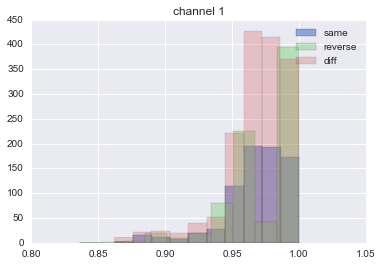

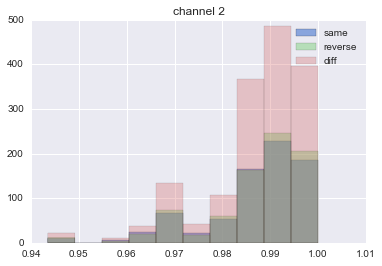

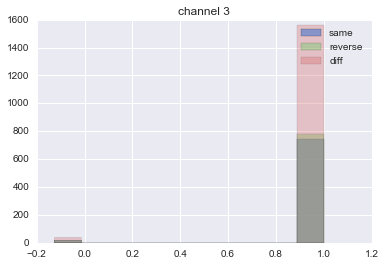

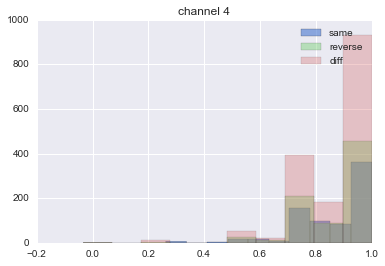

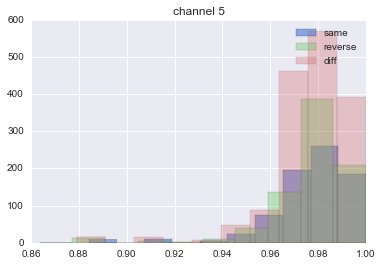

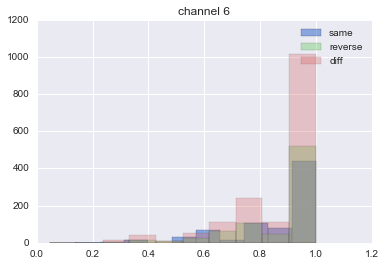

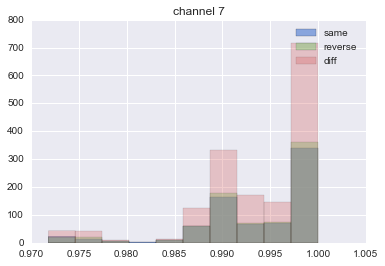

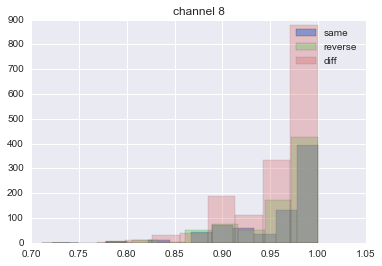

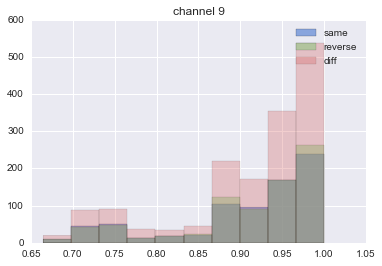

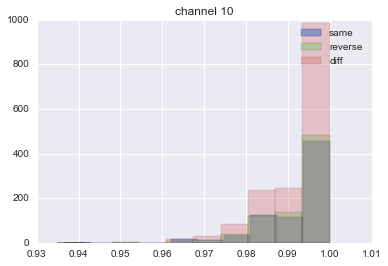

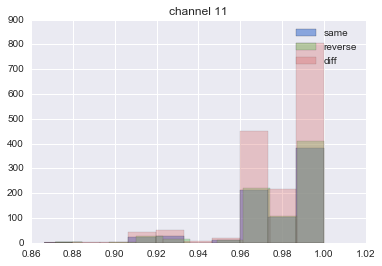

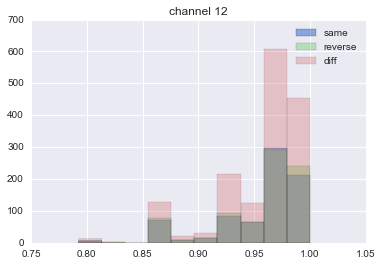

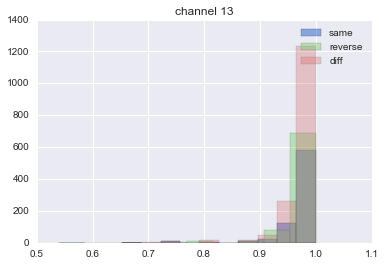

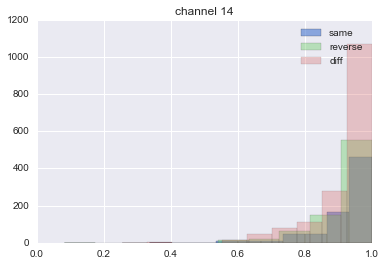

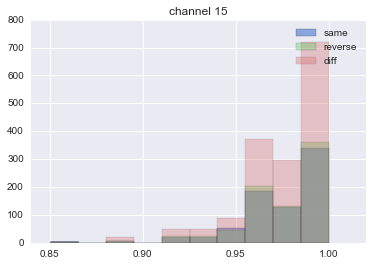

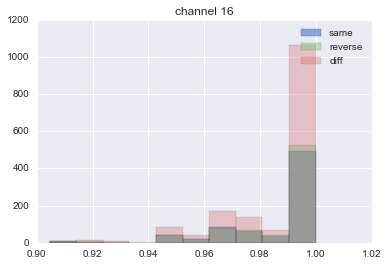

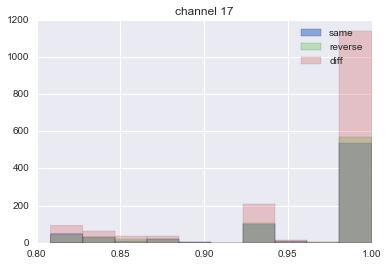

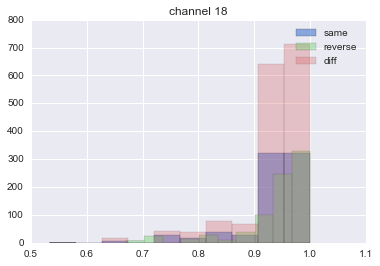

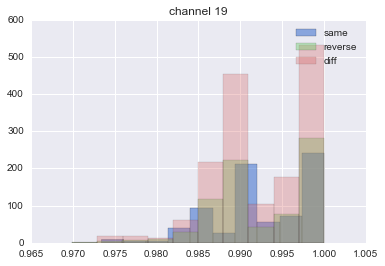

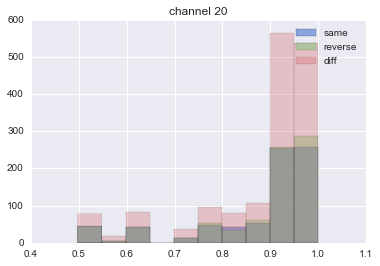

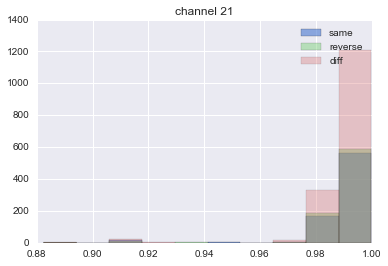

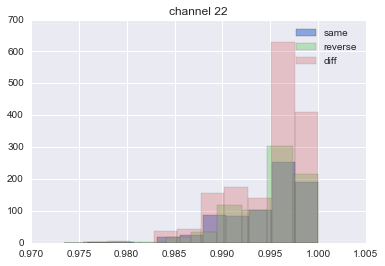

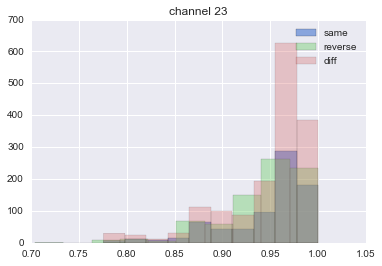

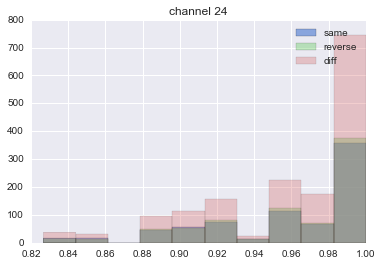

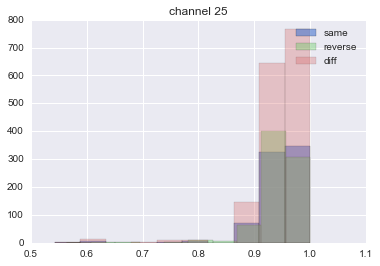

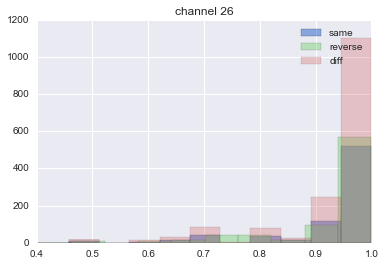

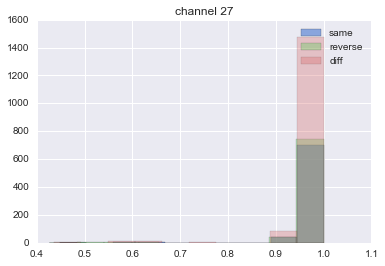

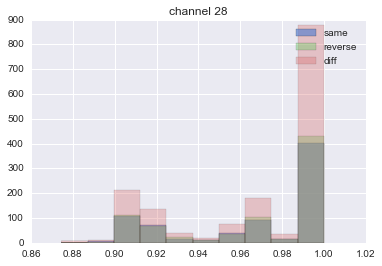

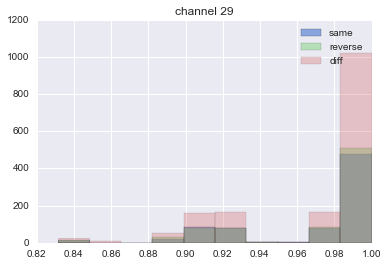

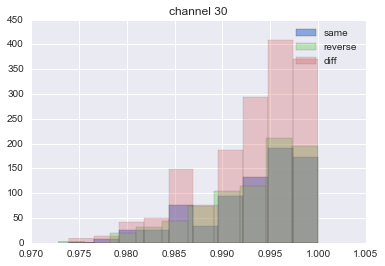

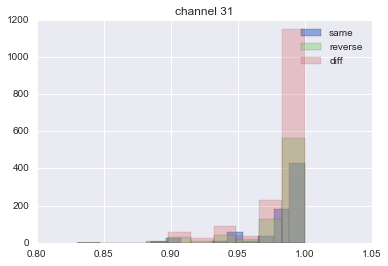

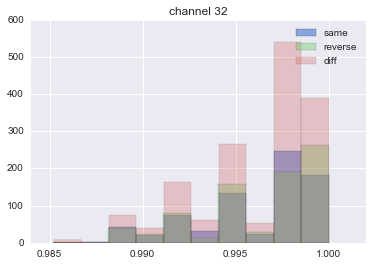

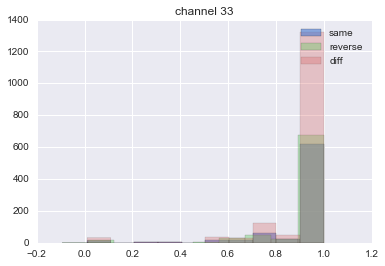

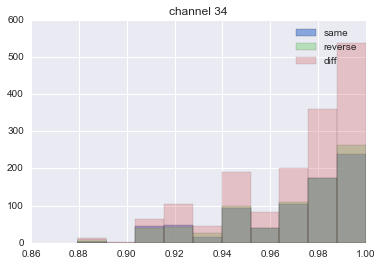

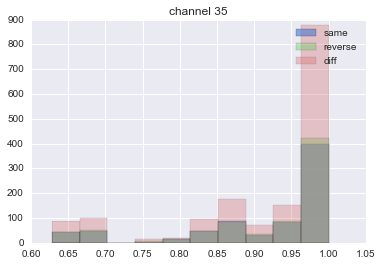

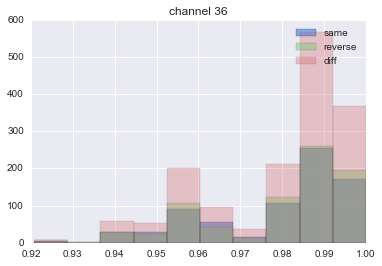

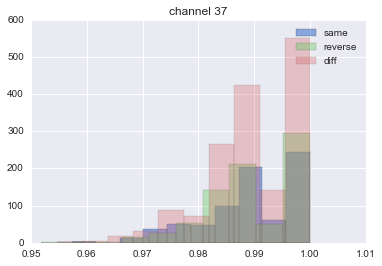

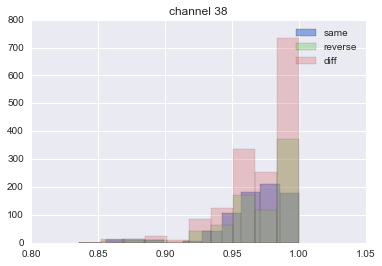

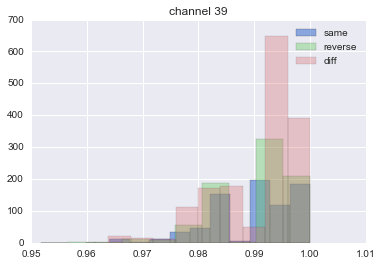

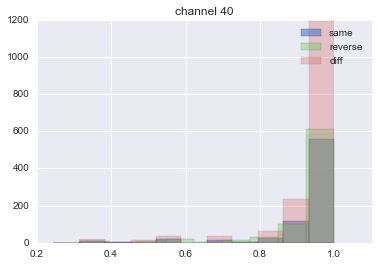

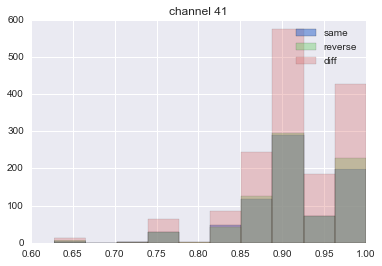

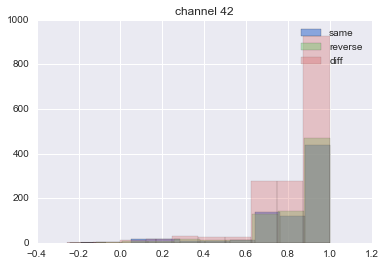

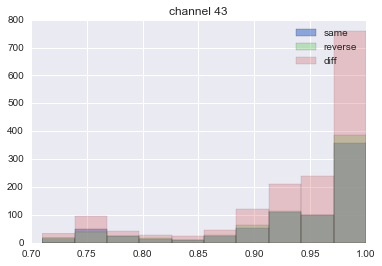

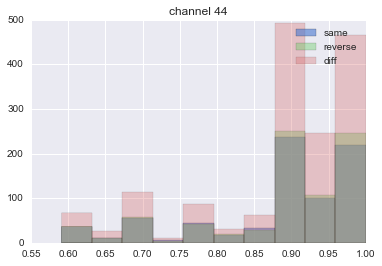

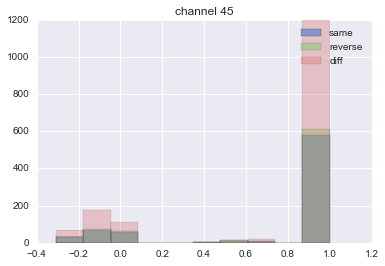

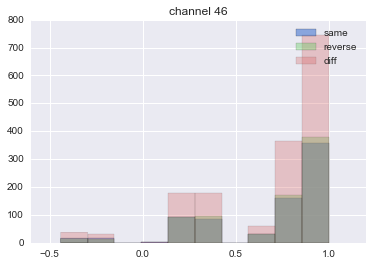

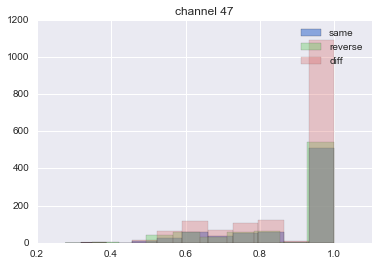

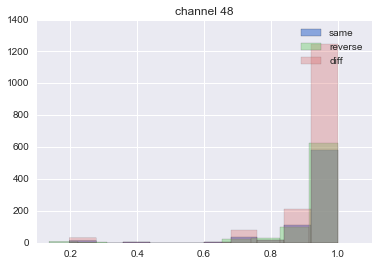

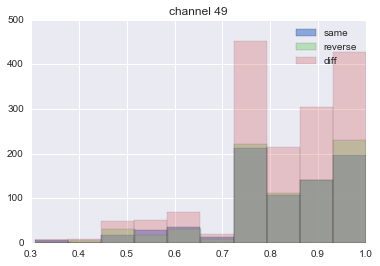

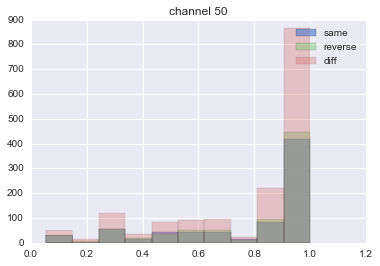

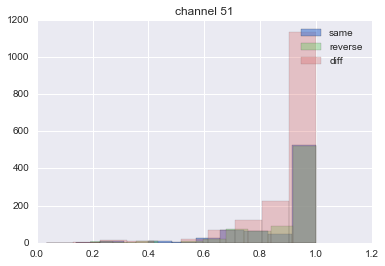

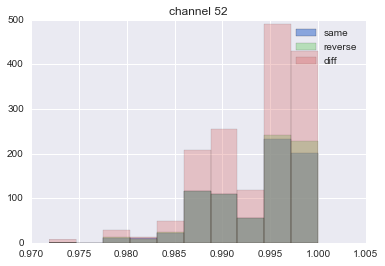

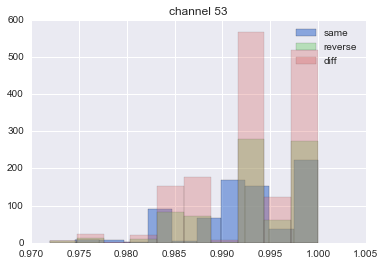

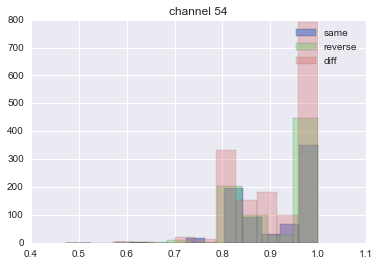

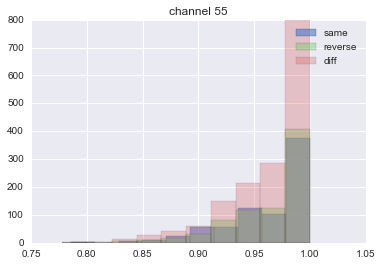

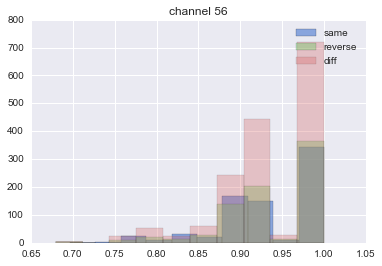

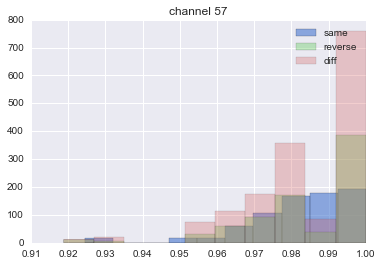

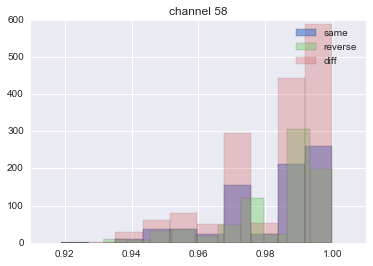

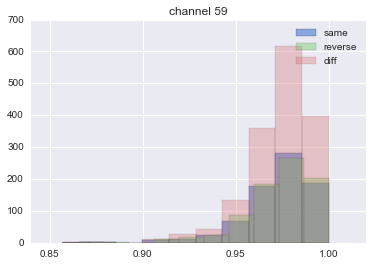

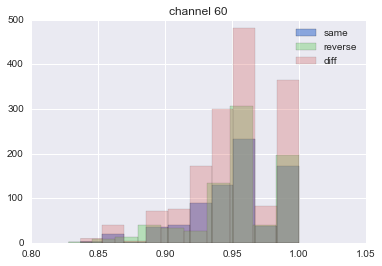

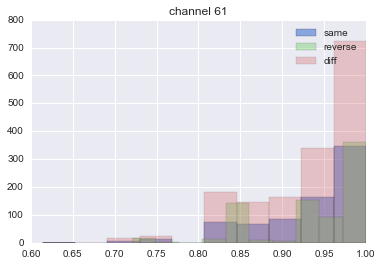

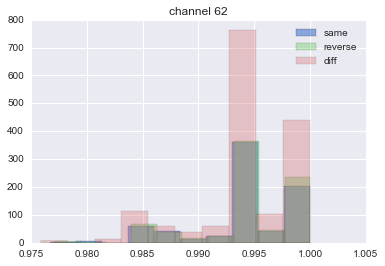

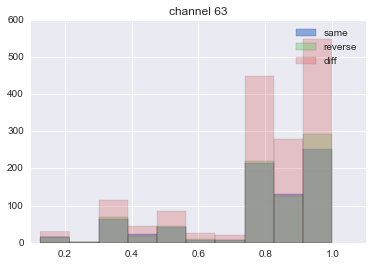

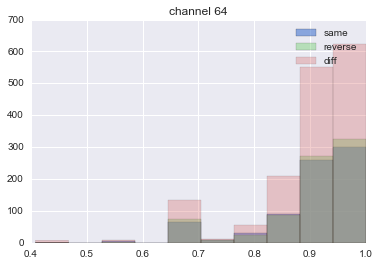

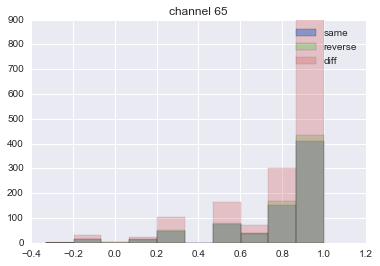

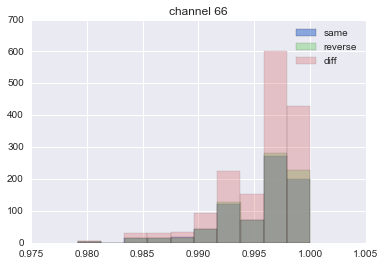

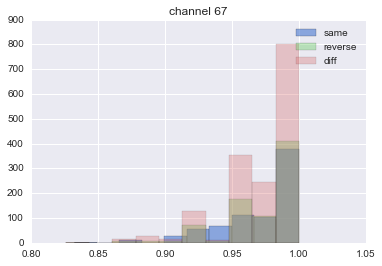

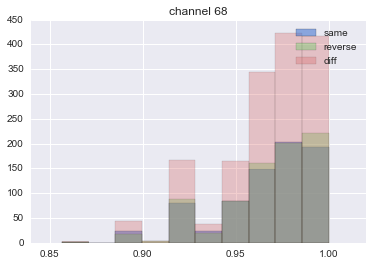

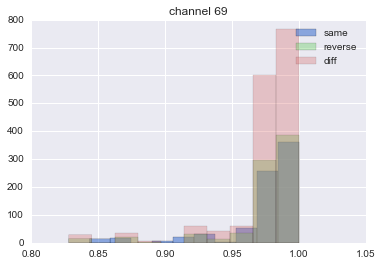

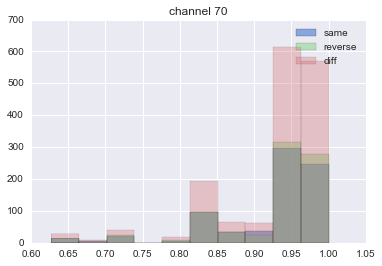

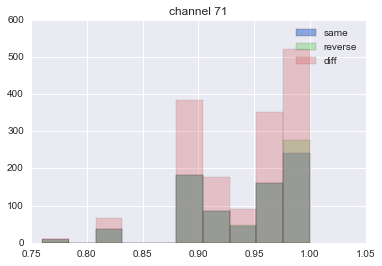

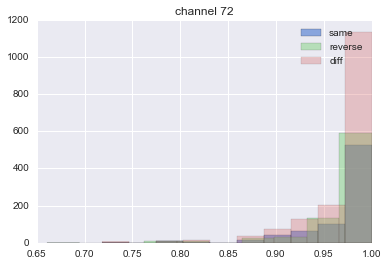

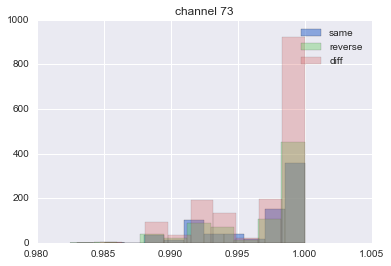

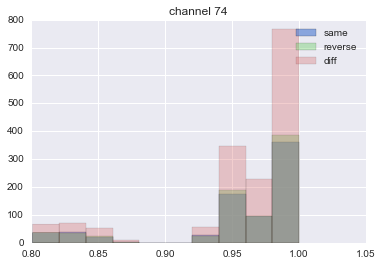

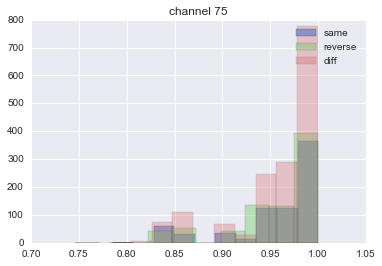

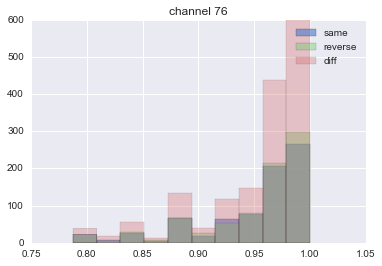

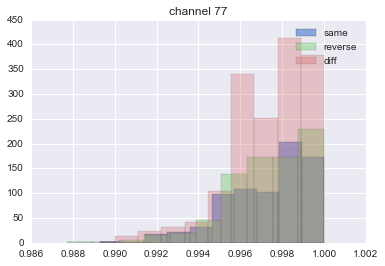

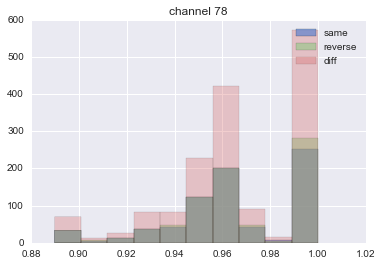

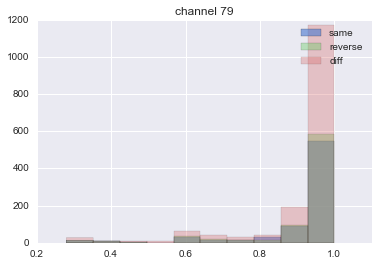

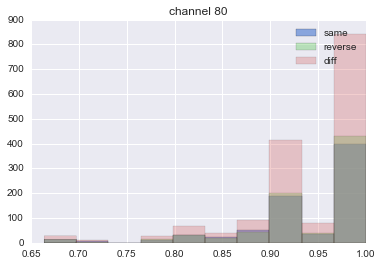

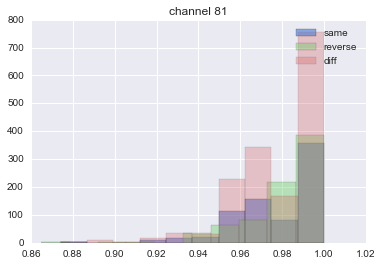

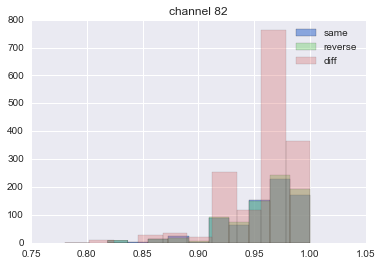

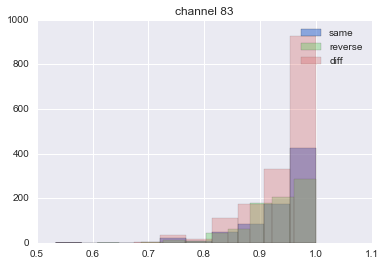

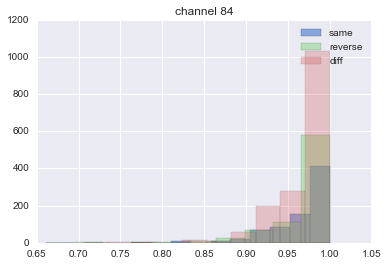

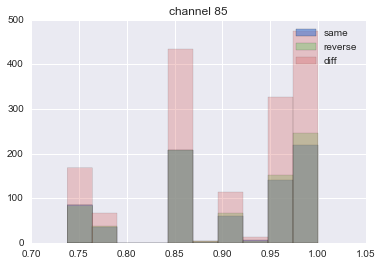

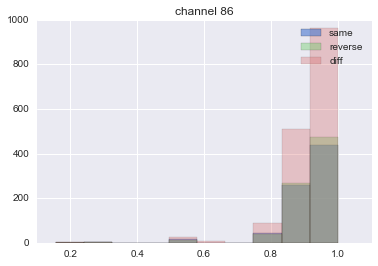

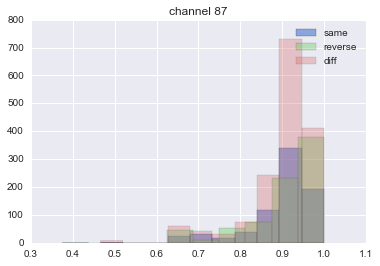

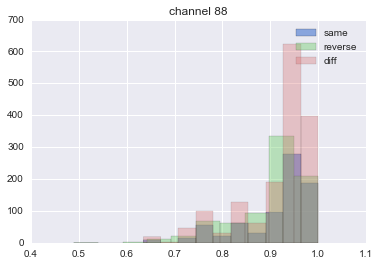

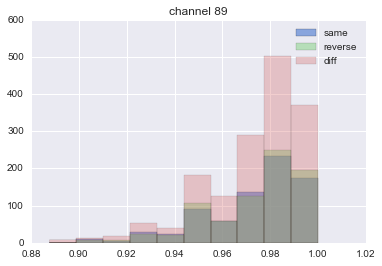

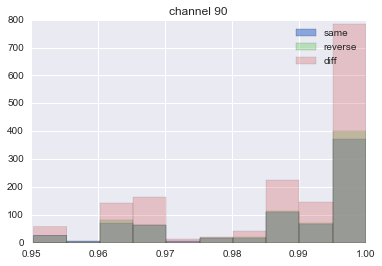

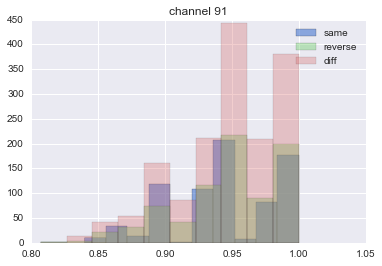

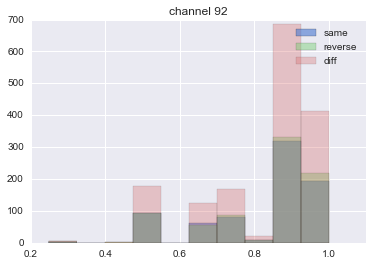

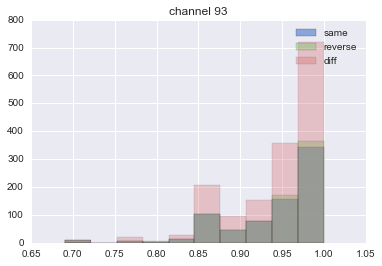

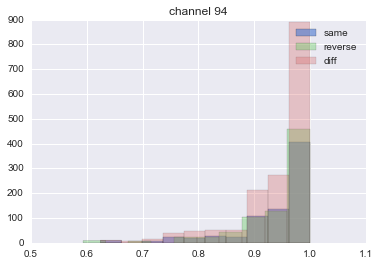

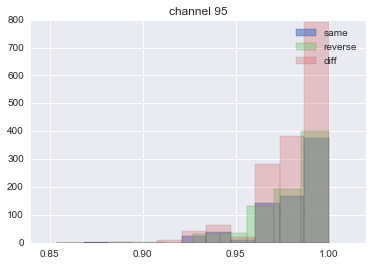

In [138]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH034'
filedir = '../../condensed_data_NIH034/robustspec_blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
for session in sessions:
    print "Analyzing session ", session, " WITHIN BLOCKS."
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # initialize p-value matrices to visualize heat maps of significant channels
    session_pval_diff_mat = np.array(())
    session_pval_same_mat = np.array(())
    session_pval_reverse_mat = np.array(())
    
    # loop through each block one at a time, analyze
    for i in range(0, 6):
        print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        
        print "These are the wordpairs in this block: ", wordpairs
        
        ################# 01: Create WordPair Groups #################
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])
        
        # extract entire data set for this session/block
        block_data = extractSubjSessionBlockData(subj, session, block)
        
        ################# 02: Analyze Significant Differences Between Same/Reverse/Different #################
        channels = np.arange(1, 96, 1)
        for jdx, chan in enumerate(channels):
            
            ################# 02a: Same Words Cosine Distnace #################
            # extract channel data for same word group
            same_word_dict = {}
            same_word_distances = []
            for same_words in same_word_group:
                same_word_data = []
                
                # extract data to process - average across time 
                same_word_key = same_words[0]
                probeOnTime = block_data[same_word_key][str(chan)]['timeZero']
                vocalizationTime = block_data[same_word_key][str(chan)]['timeVocalization']
                powerMat = block_data[same_word_key][str(chan)]['powerMat']
                
                for i in range(0, len(vocalizationTime)):
                    # either go from timezero -> vocalization, or some other timewindow
                    same_word_data.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
                same_word_data = np.array(same_word_data)
                # do a pairwise comparison of all events in this word pair
                same_word_data, check_cols = computeWithinDistances(same_word_data)
                same_word_dict[same_word_key] = same_word_data
                
            for key in same_word_dict.keys():
                same_word_distances.append(same_word_dict[key])
            same_word_distances = np.array(same_word_distances)

            ################# 02b: Reverse Words Cosine Distnace #################
            # extract channel data for same word group
            reverse_word_dict = {}
            reverse_word_distances = []
            for reverse_words in reverse_word_group:
                reverse_word_data = {}
                
                # extract data to process - average across time 
                for wdx, word in enumerate(reverse_words): # get the first and second word pair
                    reverse_word_databuffer = []
                    
                    # extract wordKey and data from MAIN block dictinoary
                    reverse_word_key = reverse_words[wdx]
                    probeOnTime = block_data[reverse_word_key][str(chan)]['timeZero']
                    vocalizationTime = block_data[reverse_word_key][str(chan)]['timeVocalization']
                    powerMat = block_data[reverse_word_key][str(chan)]['powerMat']
                    
                    # average across time and append a frequency feature vector for every event in this group
                    for i in range(0, len(vocalizationTime)):
                        # either go from timezero -> vocalization, or some other timewindow
                        reverse_word_databuffer.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
                    reverse_word_data[str(wdx)] = np.array(reverse_word_databuffer)
                    
                # do a pairwise comparison of all events in this word pair
                reverse_word_dict['vs'.join(reverse_words)] = computePairDistances(reverse_word_data['0'], reverse_word_data['1'])

            for key in reverse_word_dict.keys():
                reverse_word_distances.append(reverse_word_dict[key])
            reverse_word_distances = np.array(reverse_word_distances)

            ################# 02c: Different Words Cosine Distnace #################
            # extract channel data for same word group
            diff_word_dict = {}
            diff_word_distances = []
            for diff_words in diff_word_group:
                diff_word_data = {}
                
                # extract data to process - average across time 
                for wdx, word in enumerate(diff_words): # get the first and second word pair
                    diff_word_databuffer = []
                    
                    # extract wordKey and data from MAIN block dictinoary
                    diff_word_key = diff_words[wdx]
                    probeOnTime = block_data[diff_word_key][str(chan)]['timeZero']
                    vocalizationTime = block_data[diff_word_key][str(chan)]['timeVocalization']
                    powerMat = block_data[diff_word_key][str(chan)]['powerMat']
                    
                    # average across time and append a frequency feature vector for every event in this group
                    for i in range(0, len(vocalizationTime)):
                        # either go from timezero -> vocalization, or some other timewindow
                        diff_word_databuffer.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
                    diff_word_data[str(wdx)] = np.array(diff_word_databuffer)
                    
                # do a pairwise comparison of all events in this word pair
                diff_word_dict['vs'.join(diff_words)] = computePairDistances(diff_word_data['0'], diff_word_data['1'])
            # put all word distances into 1 list
            for key in diff_word_dict.keys():
                diff_word_distances.append(diff_word_dict[key])
            diff_word_distances = np.array(diff_word_distances)
            
#             print same_word_group
#             print reverse_word_group
#             print diff_word_group, '\n\n'
#             print same_word_dict.keys()
#             print reverse_word_dict.keys()
#             print diff_word_dict.keys()
            fig = plt.figure()
            axes = plt.gca()
            x_range = [-1, 1]
#             axes.plot(stats.gaussian_kde(np.ndarray.flatten(same_word_distances)).evaluate(x_range), label='same', alpha=0.6)
#             axes.plot(stats.gaussian_kde(np.ndarray.flatten(reverse_word_distances)).evaluate(x_range), label='reverse', alpha=0.4)
#             axes.plot(stats.gaussian_kde(np.ndarray.flatten(diff_word_distances)).evaluate(x_range), label='diff', alpha=0.3)

            axes.hist(np.ndarray.flatten(same_word_distances), label='same', alpha=0.6)
            axes.hist(np.ndarray.flatten(reverse_word_distances), label='reverse', alpha=0.4)
            axes.hist(np.ndarray.flatten(diff_word_distances), label='diff', alpha=0.3)
            axes.set_title('channel ' + str(chan))
            plt.legend()
            
#             fig = plt.figure()
#             axes = plt.gca()
#             axes.hist(same_word_dict['BRICK_CLOCK'], label='same', alpha=0.4)
#             axes.hist(reverse_word_dict['BRICK_CLOCKvsCLOCK_BRICK'], label='reverse', alpha=0.4)
#             axes.hist(diff_word_dict['BRICK_CLOCKvsJUICE_GLASS'], label='diff', alpha=0.4)
#             plt.legend()
            
#             fig = plt.figure()
#             axes = plt.gca()
#             axes.hist(same_word_dict['GLASS_JUICE'], label='same', alpha=0.4)
#             axes.hist(reverse_word_dict['GLASS_JUICEvsJUICE_GLASS'], label='reverse', alpha=0.4)
#             axes.hist(diff_word_dict['CLOCK_BRICKvsGLASS_JUICE'], label='diff', alpha=0.4)
#             plt.legend()
#             fig = plt.figure()
#             axes = plt.gca()
#             for i, key in enumerate(same_word_dict.keys()):
#                 axes.hist(same_word_dict[key], label=key)
#             plt.title('Reverse Word Distances Between Freq. Spectral Features')
#             plt.legend()
    
#             fig = plt.figure()
#             axes = plt.gca()
#             for i, key in enumerate(reverse_word_dict.keys()):
#                 axes.hist(reverse_word_dict[key], label=key)
#             plt.title('Reverse Word Distances Between Freq. Spectral Features')
#             plt.legend()
            
#             fig = plt.figure()
#             axes = plt.gca()
#             for i, key in enumerate(diff_word_dict.keys()):
#                 axes.hist(diff_word_dict[key], label=key)
#             plt.title('Different Word Distances Between Freq. Spectral Features')
#             plt.legend()
            
#             break # channel loop
        break # block loop
    break # session loop

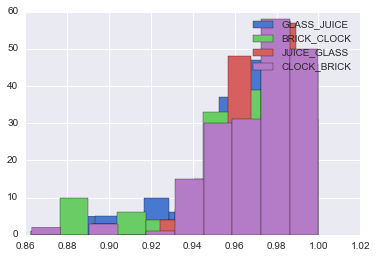

In [131]:
fig = plt.figure()
axes = plt.gca() 
for i, key in enumerate(same_word_dict.keys()):
    axes.hist(same_word_dict[key], label=key)
plt.legend()
# d = {'CLOVER':4,'SPADE':6,'DIAMOND':7,'HEART':2}
# X = np.arange(len(d))
# pl.bar(X, d.values(), align='center', width=0.5)
# pl.xticks(X, d.keys())
# ymax = max(d.values()) + 1
# pl.ylim(0, ymax)
# pl.show()

# Discussion:

Possibilities for non separation of spectral feature distances:
1. This patient could just be a non-significant one. -> analyze NIH039 next
2. Not getting the correct time points.
3. Not getting the correct frequency points.
4. Too much noise since this is a sparse spectral representation, many are close to 0, split into low, intermediate and high frequencies. -> low = [0 -> 30], intermediate = [30 -> 90], high = [90 -> rest]
5. 

(array([    16.,    148.,   1316.,   5175.,  10687.,  12135.,   7510.,
          2572.,    414.,     27.]),
 array([-0.42108121, -0.34002785, -0.25897448, -0.17792112, -0.09686776,
        -0.01581439,  0.06523897,  0.14629233,  0.22734569,  0.30839906,
         0.38945242]),
 <a list of 10 Patch objects>)

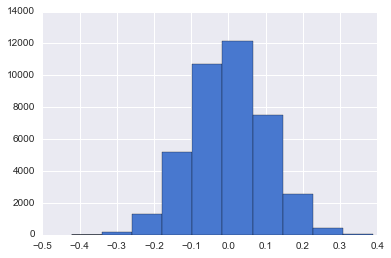

In [135]:
test = np.random.randn(200, 100)
test2 = np.random.randn(200, 100)

result = computePairDistances(test, test2)

fig=plt.figure()
plt.hist(result)
# plt.plot(stats.gaussian_kde(result))